### 1. Data Reading

In [1]:
import polars as pl

dfs = []
for month in range(1, 13):
    df = pl.scan_parquet(f"data/{month}.parquet")
    df = df.with_columns(
        pl.col("tpep_pickup_datetime").dt.cast_time_unit("ms"),
        pl.col("tpep_dropoff_datetime").dt.cast_time_unit("ms"),
    )
    dfs.append(df)

df_taxi_lookup = pl.scan_csv("data/taxi_zone_lookup.csv")
df: pl.LazyFrame = pl.concat(dfs)

In [2]:
df_2024 = (
    df
    .filter(
        pl.col("tpep_pickup_datetime").dt.year() == 2024,
        pl.col("tpep_dropoff_datetime").dt.date() <= pl.date(2025, 1, 1),
    )
    .with_columns(
        pl.col("VendorID").cast(pl.UInt8),
        pl.col("passenger_count").cast(pl.UInt8),
        pl.col("store_and_fwd_flag").cast(pl.Categorical),
        pl.col("RatecodeID").cast(pl.UInt8),
        pl.col("PULocationID").cast(pl.UInt16),
        pl.col("DOLocationID").cast(pl.UInt16),
        pl.col("payment_type").cast(pl.UInt8),
    )
)

In [4]:
df_2024.head().collect()

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
u8,datetime[ms],datetime[ms],u8,f64,u8,cat,u16,u16,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""",186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,"""N""",140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,"""N""",236,79,1,23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,"""N""",79,211,1,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,"""N""",211,148,1,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0


### 2. Data Cleaning and filtering

In [6]:
money_related_cols = [
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee"
]

ratecode_id_values = [1, 2, 3, 4, 5, 6, 99]
vendor_id_values = [1, 2, 6, 7]

df_cleaned = (
    df_2024
    .with_columns(
        pl.col("passenger_count")
        .fill_null(1)
    )
    .filter(pl.col("passenger_count") > 0)
    .with_columns(
        pl.when(pl.col("passenger_count") > 6)
        .then(pl.lit(6))
        .otherwise(pl.col("passenger_count"))
        .alias("passenger_count")
    )
    .with_columns(
        (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
        .dt.total_minutes()
        .alias("trip_time")
    )
    .filter(pl.col("trip_time") <= 120)
    .with_columns([pl.col(column_name).abs() for column_name in money_related_cols])
    .filter([pl.col(column_name) <= 1000 for column_name in money_related_cols])
    .filter(
        pl.col("RatecodeID").is_not_null(),
        pl.col("RatecodeID").is_in(ratecode_id_values),
        pl.col("VendorID").is_not_null(),
        pl.col("VendorID").is_in(vendor_id_values),
    )

)

In [7]:
df_cleaned.head().collect()

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_time
u8,datetime[ms],datetime[ms],u8,f64,u8,cat,u16,u16,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""",186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0,19
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,"""N""",140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,6
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,"""N""",236,79,1,23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0,17
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,"""N""",79,211,1,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0,8
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,"""N""",211,148,1,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0,6


### 3. Data Transformation

In [9]:
week_day_expr = pl.col("tpep_pickup_datetime").dt.weekday().is_between(1, 5)
first_hour_expr = (
    (pl.col("tpep_pickup_datetime").dt.time() >= pl.time(6, 30)) & 
    (pl.col("tpep_pickup_datetime").dt.time() < pl.time(9, 30))
)
second_hour_expr = (
    (pl.col("tpep_pickup_datetime").dt.time() >= pl.time(15, 30)) &
    (pl.col("tpep_pickup_datetime").dt.time() < pl.time(20))
)

rush_hour_expr = week_day_expr & (first_hour_expr | second_hour_expr)


df_transformed = (
    df_cleaned
    .with_columns(
        pl.when(pl.col("payment_type") == 1)
        .then(pl.lit("card"))
        .when(pl.col("payment_type") == 2)
        .then(pl.lit("cash"))
        .otherwise(pl.lit("other"))
        .alias("payment_type")
        .cast(pl.Categorical)
    )
    .join(df_taxi_lookup.select("LocationID", "Borough"), left_on="PULocationID", right_on="LocationID")
    .with_columns(pl.col("Borough").alias("PUBorough"))
    .drop("Borough", "PULocationID")
    .join(df_taxi_lookup.select("LocationID", "Borough"), left_on="DOLocationID", right_on="LocationID")
    .with_columns(pl.col("Borough").alias("DOBorough"))
    .drop("Borough", "DOLocationID")
    .with_columns((pl.col("Airport_fee") > 0).alias("is_airport_ride"))
    .with_columns(rush_hour_expr.alias("is_rush_hour"))
)

In [10]:
df_transformed.head().collect()

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_time,PUBorough,DOBorough,is_airport_ride,is_rush_hour
u8,datetime[ms],datetime[ms],u8,f64,u8,cat,cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,bool,bool
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""","""cash""",17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0,19,"""Manhattan""","""Manhattan""",false,false
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,"""N""","""card""",10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,6,"""Manhattan""","""Manhattan""",false,false
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,"""N""","""card""",23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0,17,"""Manhattan""","""Manhattan""",false,false
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,"""N""","""card""",10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0,8,"""Manhattan""","""Manhattan""",false,false
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,"""N""","""card""",7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0,6,"""Manhattan""","""Manhattan""",false,false


### 4. Feature extraction

In [11]:
(
    df_transformed
    .collect()
    .to_dummies(["payment_type", "PUBorough", "DOBorough"])
    .group_by(pl.col("tpep_pickup_datetime").dt.date().alias("date"))
    .agg(
        pl.col("^(DOBorough|PUBorough|payment_type)_.*$").sum(),
        pl.col("is_airport_ride").sum().alias("airport_ride_count"),
        pl.col("is_rush_hour").sum().alias("rush_hour_ride_count"),
        pl.col("passenger_count").sum().alias("total_passenger_count"),
        pl.col("fare_amount").mean().alias("mean_fare_amount"),
        pl.col("trip_distance").median().alias("median_trip_distance"),
        pl.col("total_amount").sum(),
        pl.col("congestion_surcharge").sum(),
        pl.len().alias("total_rides")
    )
    .with_columns(
        pl.col("date").dt.quarter().alias("quarter"),
        pl.col("date").dt.month().alias("month"),
        pl.col("date").dt.day().alias("day_of_month"),
        pl.col("date").dt.weekday().alias("day_of_week"),
        pl.col("date").dt.weekday().is_between(6, 7).alias("is_weekend")
    )
    .write_parquet("data/dataset.parquet")
)

### 5. Data Analysis

In [16]:
df = pl.read_parquet("data/dataset.parquet")

In [17]:
df.shape

(366, 33)

In [18]:
df.head()

date,payment_type_card,payment_type_cash,payment_type_other,PUBorough_Bronx,PUBorough_Brooklyn,PUBorough_EWR,PUBorough_Manhattan,PUBorough_N/A,PUBorough_Queens,PUBorough_Staten Island,PUBorough_Unknown,DOBorough_Bronx,DOBorough_Brooklyn,DOBorough_EWR,DOBorough_Manhattan,DOBorough_N/A,DOBorough_Queens,DOBorough_Staten Island,DOBorough_Unknown,airport_ride_count,rush_hour_ride_count,total_passenger_count,mean_fare_amount,median_trip_distance,total_amount,congestion_surcharge,total_rides,quarter,month,day_of_month,day_of_week,is_weekend
date,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,u32,u32,i64,f64,f64,f64,f64,u32,i8,i8,i8,i8,bool
2024-12-01,71259,13306,3649,153,892,22,71653,83,15117,6,288,497,4757,270,75936,590,5742,19,403,13964,0,125683,22.46811,1.86,2.8205e6,196888.5,88214,4,12,1,7,true
2024-03-14,98268,17004,2776,242,1032,14,106240,67,10073,0,380,677,4565,318,105749,461,5683,19,576,8917,48969,153586,19.63615,1.72,3.4335e6,275137.5,118048,1,3,14,4,false
2024-04-04,94891,16716,2756,219,955,15,101246,47,11510,1,370,605,4337,317,102434,493,5591,20,566,10381,45948,151778,19.731659,1.7,3.3376e6,263692.5,114363,2,4,4,4,false
2024-12-07,108582,17569,4498,161,961,31,120105,89,8856,3,443,525,4708,289,118909,543,5043,18,614,7806,0,189257,19.46182,1.61,3.6302e6,306871.0,130649,4,12,7,6,true
2024-08-16,69247,15040,3258,255,1062,20,76308,72,9554,1,273,670,3938,271,76585,539,5138,30,374,8398,33398,122026,20.203596,1.74,2.5674e6,197025.0,87545,3,8,16,5,false


In [19]:
df.describe()

statistic,date,payment_type_card,payment_type_cash,payment_type_other,PUBorough_Bronx,PUBorough_Brooklyn,PUBorough_EWR,PUBorough_Manhattan,PUBorough_N/A,PUBorough_Queens,PUBorough_Staten Island,PUBorough_Unknown,DOBorough_Bronx,DOBorough_Brooklyn,DOBorough_EWR,DOBorough_Manhattan,DOBorough_N/A,DOBorough_Queens,DOBorough_Staten Island,DOBorough_Unknown,airport_ride_count,rush_hour_ride_count,total_passenger_count,mean_fare_amount,median_trip_distance,total_amount,congestion_surcharge,total_rides,quarter,month,day_of_month,day_of_week,is_weekend
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""366""",366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0,366.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2024-07-01 12:00:00""",82243.830601,14924.087432,2932.131148,206.300546,882.538251,15.983607,88511.467213,60.191257,10108.349727,2.579235,312.639344,590.284153,4009.330601,284.546448,89044.153005,484.877049,5212.691257,25.262295,448.904372,8979.101093,29941.095628,134964.92623,19.953976,1.718675,2.9114e6,230208.430383,100100.04918,2.505464,6.513661,15.756831,3.986339,0.284153
"""std""",null,14160.573152,1357.339405,554.555287,51.234859,201.994378,7.71263,15153.596893,18.118832,1764.486159,1.735371,57.286839,67.926964,581.722188,73.626133,14677.21722,93.822121,689.092471,6.750509,92.056708,1715.760237,19693.567643,18723.833939,1.204506,0.100871,461524.764162,37862.395531,15371.426417,1.119551,3.455958,8.823592,2.006108,null
"""min""","""2024-01-01""",34052.0,10244.0,1656.0,48.0,298.0,2.0,41757.0,23.0,4935.0,0.0,149.0,370.0,1831.0,122.0,41657.0,261.0,2827.0,9.0,192.0,3355.0,0.0,74199.0,16.676264,1.5,1.3260e6,107825.0,47391.0,1.0,1.0,1.0,1.0,0.0
"""25%""","""2024-04-01""",72543.0,14109.0,2566.0,166.0,731.0,10.0,77350.0,46.0,8862.0,1.0,273.0,545.0,3682.0,236.0,78535.0,418.0,4773.0,20.0,390.0,7869.0,0.0,122222.0,19.125929,1.66,2.5818e6,203501.0,89573.0,2.0,4.0,8.0,2.0,null
"""50%""","""2024-07-02""",83419.0,14966.0,2910.0,216.0,938.0,15.0,89891.0,59.0,10073.0,2.0,310.0,591.0,4009.0,275.0,90293.0,481.0,5252.0,25.0,444.0,9020.0,39515.0,134084.0,19.953055,1.7,2.9166e6,232825.0,100782.0,3.0,7.0,16.0,4.0,null
"""75%""","""2024-10-01""",91739.0,15835.0,3271.0,243.0,1019.0,20.0,99602.0,70.0,11254.0,3.0,347.0,639.0,4378.0,335.0,99447.0,549.0,5703.0,30.0,515.0,10144.0,44782.0,147190.0,20.713722,1.77,3.2229e6,256942.0,110805.0,4.0,10.0,23.0,6.0,null
"""max""","""2024-12-31""",120997.0,17994.0,4596.0,324.0,1674.0,47.0,128161.0,125.0,16177.0,8.0,505.0,801.0,6237.0,583.0,127687.0,716.0,6851.0,51.0,718.0,14904.0,56580.0,199442.0,24.447593,2.2,4.4645e6,330475.0,141702.0,4.0,12.0,31.0,7.0,1.0


In [20]:
df.schema

Schema([('date', Date),
        ('payment_type_card', Int64),
        ('payment_type_cash', Int64),
        ('payment_type_other', Int64),
        ('PUBorough_Bronx', Int64),
        ('PUBorough_Brooklyn', Int64),
        ('PUBorough_EWR', Int64),
        ('PUBorough_Manhattan', Int64),
        ('PUBorough_N/A', Int64),
        ('PUBorough_Queens', Int64),
        ('PUBorough_Staten Island', Int64),
        ('PUBorough_Unknown', Int64),
        ('DOBorough_Bronx', Int64),
        ('DOBorough_Brooklyn', Int64),
        ('DOBorough_EWR', Int64),
        ('DOBorough_Manhattan', Int64),
        ('DOBorough_N/A', Int64),
        ('DOBorough_Queens', Int64),
        ('DOBorough_Staten Island', Int64),
        ('DOBorough_Unknown', Int64),
        ('airport_ride_count', UInt32),
        ('rush_hour_ride_count', UInt32),
        ('total_passenger_count', Int64),
        ('mean_fare_amount', Float64),
        ('median_trip_distance', Float64),
        ('total_amount', Float64),
        ('conges

<Axes: ylabel='Frequency'>

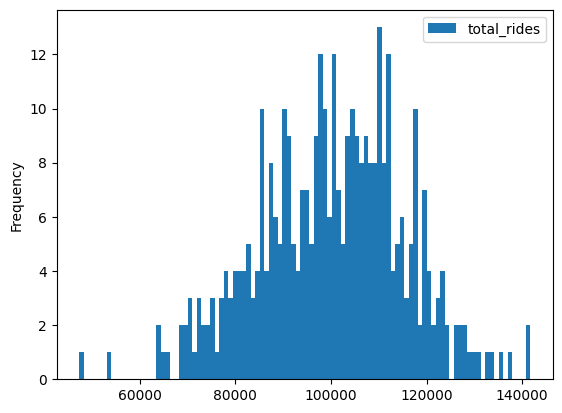

In [21]:
(
    df.select("total_rides")
    .to_pandas()
    .plot.hist(bins=100)
)

<Axes: xlabel='date'>

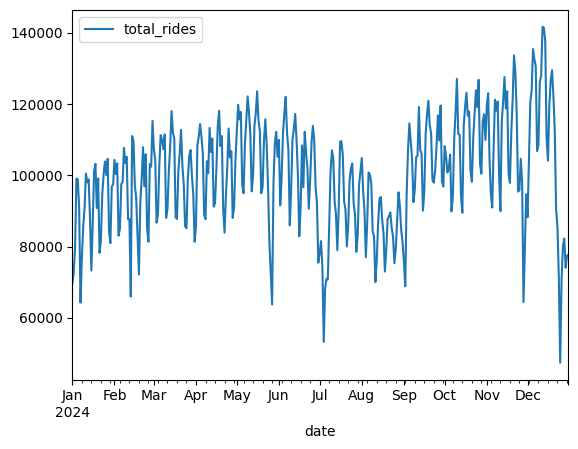

In [22]:
(
    df
    .select("date", "total_rides")
    .sort(by="date")
    .to_pandas()
    .plot(x="date", y="total_rides")
)